In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')
data_df.head()

input_ct  selected_ct  hamming_dist  training_set         y  \
0     173.0         33.0             2          True -3.145154   
1      18.0          8.0             2         False -1.867676   
2      66.0          2.0             2          True -5.270800   
3      72.0          1.0             2         False -5.979498   
4      69.0        168.0             2          True  0.481923   

                                                   x  
0  AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...  
1  ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...  
2  ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...  
3  AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...  
4  AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...

In [3]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 424,706
testing N: 106,031


In [4]:
# Set filename
name = 'gb1_ge_blackbox'

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein',
                     gpmap_type='blackbox',
                     gpmap_kwargs={
                         'hidden_layer_sizes':[100]*5
                     },
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [5]:
# Set training data
model.set_data(x=train_df['x'],
               y=train_df['y'])

N = 424,706 observations set as training data.
Data shuffled.
Time to set data: 11.6 sec.


In [6]:
# Fit model to data
history = model.fit(learning_rate=.0003,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=20,
                    linear_initialization=False)

Epoch 1/1000
340/340 [==============================] - 7s 21ms/step - loss: 1108.6771 - I_like: 0.2341 - val_loss: 919.4260 - val_I_like: 0.4933
Epoch 2/1000
340/340 [==============================] - 6s 18ms/step - loss: 800.9031 - I_like: 0.6604 - val_loss: 686.8157 - val_I_like: 0.8222
Epoch 3/1000
340/340 [==============================] - 7s 19ms/step - loss: 581.9412 - I_like: 0.9731 - val_loss: 475.7815 - val_I_like: 1.1256
Epoch 4/1000
340/340 [==============================] - 7s 20ms/step - loss: 383.6731 - I_like: 1.2586 - val_loss: 286.7847 - val_I_like: 1.3982
Epoch 5/1000
340/340 [==============================] - 7s 22ms/step - loss: 208.5003 - I_like: 1.5113 - val_loss: 131.3704 - val_I_like: 1.6227
Epoch 6/1000
340/340 [==============================] - 9s 28ms/step - loss: 67.9938 - I_like: 1.7146 - val_loss: -7.9749 - val_I_like: 1.8244
Epoch 7/1000
340/340 [==============================] - 7s 20ms/step - loss: -60.5162 - I_like: 1.9005 - val_loss: -100.7232 - val_

In [7]:
# Save model
model.save(name)

Model saved to these files:
	gb1_ge_blackbox.pickle
	gb1_ge_blackbox.h5


In [8]:
# Load model
model = mavenn.load(name)

Model loaded from these files:
	gb1_ge_blackbox.pickle
	gb1_ge_blackbox.h5


In [9]:
!du -k gb1_ge_blackbox.*

640	gb1_ge_blackbox.h5
16	gb1_ge_blackbox.pickle


In [10]:
# Subsample indices for easy plotting and information estimation
N_test = len(test_df)
ix = np.random.rand(N_test) < .1

# Get x and y
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

On test data:
I_like_test: 2.570 +- 0.019 bits
I_pred_test: 2.744 +- 0.012 bits


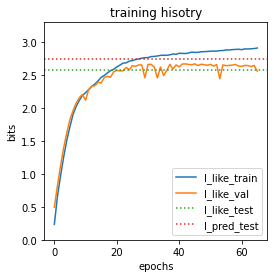

In [11]:
# Show training history
print('On test data:')

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x, y=y)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x, y=y)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

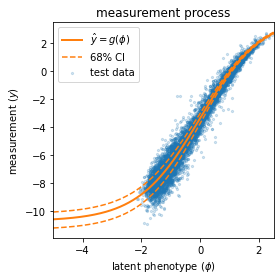

In [12]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [13]:
# Test simulate_data
sim_df = model.simulate_dataset(N=1000)
sim_df.head()

training_set      yhat       phi         y  \
0          True -6.769110 -1.057737 -6.866087   
1          True -6.256627 -0.878229 -6.615749   
2          True -7.659273 -1.410232 -7.207937   
3          True -2.328909  0.291488 -2.613426   
4          True -4.760952 -0.409201 -4.066459   

                                                   x  
0  QYKVILNGKTLKGETTTEAVDAAPAEKVFKQYANDNGVDGEWTEDD...  
1  QYKLILNGKTLKGETTTEAVDAATAEKVFQMYANDNGVDGRWTYDD...  
2  QYKLILNGKTLKGETTTEAVDAATAEKVFKQYDNDNGVDTEWTYDD...  
3  QYKLILNGKTLKGETTTEYVDAATAERVFKQYANDNGVDGEWFYDD...  
4  QYKLILNGKTLKGETTQEAVDAATAEKVFKVYANDNGADGEWTYDD...